# Риконина Вероника КЭ-402 - Поиск ассоциативных правил

Доработайте программу из задания Поиск частых наборов, чтобы она также выполняла поиск ассоциативных правил. Список результирующих правил должен выдаваться в удобочитаемом виде (антецедент→консеквент) с указанием поддержки и достоверности каждого правила. Дополнительные параметры программы: порог достоверности, способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).

Проведите эксперименты на наборах из задания 1. В экспериментах Зафиксируйте значение пороговое значение поддержки (например, 10%), варьируйте пороговое значение достоверности (например, от 70% до 95% с шагом 5%).

Выполните визуализацию полученных результатов в виде следующих диаграмм:
 - сравнение быстродействия поиска правил на фиксированном наборе данных при изменяемом пороге достоверности;
 - общее количество найденных правил на фиксированном наборе данных при изменяемом пороге достоверности.

Подготовьте список правил, в которых антецедент и консеквент суммарно включают в себя не более семи объектов (разумное количество). Проанализируйте и изложите содержательный смысл полученного результата.

Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
 - формулировка задания;
 - гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами;
 - рисунки с результатами визуализации;
 - пояснения, раскрывающие смысл полученных результатов.


# Подключение необходимых библиотек

In [ ]:
import pandas as pd
import chardet
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import time
import matplotlib.pyplot as plt

# Импорт данных

In [ ]:
with open('baskets.csv', 'rb') as f:
    result = chardet.detect(f.read())

df = pd.read_csv('baskets.csv', encoding=result['encoding'])
df

,креветки,миндаль,авокадо,овощная смесь,зеленый виноград,цельнозерновая мука,батат,творог,энергетический напиток,томатный сок,низкокалорийный йогурт,зеленый чай,мед,салат,минеральная вода,лосось,ягодный сок,замороженный смузи,шпинат,оливковое масло
0,гамбургер,фрикадельки,яйца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,чатни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,индейка,авокадо,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,минеральная вода,молоко,энергетический батончик,рис,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,низкокалорийный йогурт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7496,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Анализ данных

In [ ]:
def find_frequent_itemsets_and_association_rules(data, min_support, min_confidence, sort_by='support'):
    # Преобразование данных в список списков для подачи в метод fit
    transactions = data.values.tolist()

    # Удаление значений NaN из транзакций
    transactions = [[item for item in transaction if not pd.isnull(item)] for transaction in transactions]

    # Преобразование в разряженную матрицу
    te = TransactionEncoder()
    te_transform = te.fit(transactions).transform(transactions)
    transactions_matrix = pd.DataFrame(te_transform, columns=te.columns_)

    # Поиск частых наборов с помощью алгоритма Apriori
    frequent_itemsets = apriori(transactions_matrix, min_support=min_support, use_colnames=True)

    # Поиск ассоциативных правил
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules["antecedent"] = rules["antecedents"].apply(lambda x: ', '.join(list(x)))
    rules["consequent"] = rules["consequents"].apply(lambda x: ', '.join(list(x)))
    rules = rules[["antecedent", "consequent", "support", "confidence"]]

    # Сортировка результатов
    if sort_by == 'support':
        frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
        rules = rules.sort_values(by='support', ascending=False)
    elif sort_by == 'lexical':
        frequent_itemsets = frequent_itemsets.sort_values(by='itemsets')
        rules = rules.sort_values(by=['antecedent', 'consequent'])

    return frequent_itemsets, rules


In [ ]:
# Проведем эксперименты
min_support = 0.002
min_confidence_values = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for min_confidence in min_confidence_values:
    frequent_itemsets, rules = find_frequent_itemsets_and_association_rules(df, min_support, min_confidence)

    # Вывод результатов в Jupyter Notebook
    display(f'Порог достоверности: {min_confidence}')
    display(pd.DataFrame(frequent_itemsets))
    display(pd.DataFrame(rules))

'Порог достоверности: 0.7'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
233,0.002000,"(соус для барбекю, блинчики)"
242,0.002000,"(фрикадельки, блинчики)"
2395,0.002000,"(шампанское, минеральная вода, молоко)"
1727,0.002000,"(яйца, низкокалорийный йогурт, говяжий фарш)"


,antecedent,consequent,support,confidence
0,"эскалоп, грибной соус",макароны,0.004267,0.744186
9,"суп, замороженные овощи, молоко",минеральная вода,0.003067,0.766667
11,"растительное масло, яйца, макароны",минеральная вода,0.003067,0.718750
10,"оливковое масло, шоколад, замороженные овощи",минеральная вода,0.002800,0.700000
13,"оливковое масло, яйца, молоко",минеральная вода,0.002667,0.714286
2,"макароны, обезжиренное молоко",минеральная вода,0.002533,0.730769
6,"креветки, замороженные овощи, говяжий фарш",макароны,0.002533,0.791667
4,"растительное масло, макароны, блинчики",минеральная вода,0.002267,0.739130
5,"макароны, суп, блинчики",минеральная вода,0.002267,0.772727
1,"красное вино, индейка",минеральная вода,0.002133,0.727273


'Порог достоверности: 0.75'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
233,0.002000,"(соус для барбекю, блинчики)"
242,0.002000,"(фрикадельки, блинчики)"
2395,0.002000,"(шампанское, минеральная вода, молоко)"
1727,0.002000,"(яйца, низкокалорийный йогурт, говяжий фарш)"


,antecedent,consequent,support,confidence
5,"суп, замороженные овощи, молоко",минеральная вода,0.003067,0.766667
2,"креветки, замороженные овощи, говяжий фарш",макароны,0.002533,0.791667
1,"макароны, суп, блинчики",минеральная вода,0.002267,0.772727
0,"рис, блинчики, говяжий фарш",минеральная вода,0.002133,0.842105
4,"оливковое масло, замороженные овощи, помидоры",макароны,0.002133,0.842105
6,"рис, помидоры, молоко",макароны,0.002133,0.800000
3,"индейка, замороженные овощи, молоко",минеральная вода,0.002000,0.750000
7,"шоколад, молоко, замороженные овощи, говяжий фарш",минеральная вода,0.002000,0.750000
8,"креветки, шоколад, макароны, замороженные овощи",минеральная вода,0.002000,0.882353


'Порог достоверности: 0.8'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
233,0.002000,"(соус для барбекю, блинчики)"
242,0.002000,"(фрикадельки, блинчики)"
2395,0.002000,"(шампанское, минеральная вода, молоко)"
1727,0.002000,"(яйца, низкокалорийный йогурт, говяжий фарш)"


,antecedent,consequent,support,confidence
0,"рис, блинчики, говяжий фарш",минеральная вода,0.002133,0.842105
1,"оливковое масло, замороженные овощи, помидоры",макароны,0.002133,0.842105
2,"рис, помидоры, молоко",макароны,0.002133,0.800000
3,"креветки, шоколад, макароны, замороженные овощи",минеральная вода,0.002000,0.882353


'Порог достоверности: 0.85'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
233,0.002000,"(соус для барбекю, блинчики)"
242,0.002000,"(фрикадельки, блинчики)"
2395,0.002000,"(шампанское, минеральная вода, молоко)"
1727,0.002000,"(яйца, низкокалорийный йогурт, говяжий фарш)"


,antecedent,consequent,support,confidence
0,"креветки, шоколад, макароны, замороженные овощи",минеральная вода,0.002,0.882353


'Порог достоверности: 0.9'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
233,0.002000,"(соус для барбекю, блинчики)"
242,0.002000,"(фрикадельки, блинчики)"
2395,0.002000,"(шампанское, минеральная вода, молоко)"
1727,0.002000,"(яйца, низкокалорийный йогурт, говяжий фарш)"


,antecedent,consequent,support,confidence


'Порог достоверности: 0.95'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
233,0.002000,"(соус для барбекю, блинчики)"
242,0.002000,"(фрикадельки, блинчики)"
2395,0.002000,"(шампанское, минеральная вода, молоко)"
1727,0.002000,"(яйца, низкокалорийный йогурт, говяжий фарш)"


,antecedent,consequent,support,confidence


# Построение графиков

In [ ]:
def plot_performance_vs_confidence(min_support, min_confidence_values):
    # Список для хранения времени выполнения
    execution_times = []

    for min_confidence in min_confidence_values:
        start_time = time.time()
        _, rules = find_frequent_itemsets_and_association_rules(df, min_support, min_confidence)
        execution_time = time.time() - start_time
        execution_times.append(execution_time)

    # Создаем диаграмму
    plt.figure(figsize=(10, 6))
    plt.plot(min_confidence_values, execution_times, marker='o')
    plt.xlabel('Порог достоверности')
    plt.ylabel('Время выполнения (сек)')
    plt.title('Сравнение быстродействия поиска правил при изменении порога достоверности')
    plt.grid(True)
    plt.show()

def plot_rule_count_vs_confidence(min_support, min_confidence_values):
    # Список для хранения количества правил
    rule_counts = []

    for min_confidence in min_confidence_values:
        frequent_itemsets, rules = find_frequent_itemsets_and_association_rules(df, min_support, min_confidence)
        rule_counts.append(len(rules))

    # Создаем диаграмму
    plt.figure(figsize=(10, 6))
    plt.plot(min_confidence_values, rule_counts, marker='o', color='r')
    plt.xlabel('Порог достоверности')
    plt.ylabel('Количество правил')
    plt.title('Общее количество найденных правил при изменении порога достоверности')
    plt.grid(True)
    plt.show()

# Настройки для экспериментов
min_support = 0.002
min_confidence_values = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


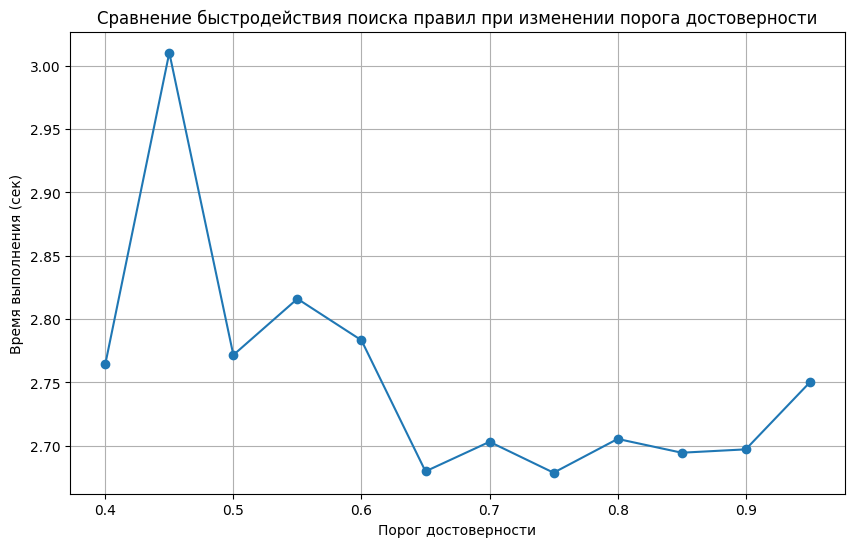

In [ ]:
plot_performance_vs_confidence(min_support, min_confidence_values)

На графике видно, что при росте порога достоверности время выполнения снижается

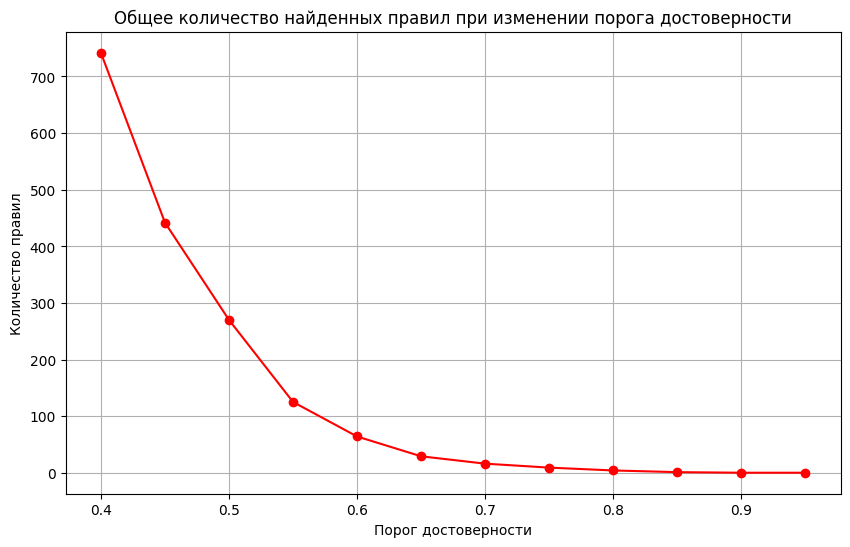

In [ ]:
plot_rule_count_vs_confidence(min_support, min_confidence_values)

На графике видно, что при значении support 0.002 и увеличении порога достоверности, количество правил начинается снижаться

При пороге 0.8 количество правил становится равной нулю

Это говорит о том, что высокая достоверность присутствует только у небольшого числа правил

In [ ]:
# Настройки для экспериментов
min_support = 0.002
min_confidence = 0.65

# Найдем все частые наборы и ассоциативные правила
frequent_itemsets, rules = find_frequent_itemsets_and_association_rules(df, min_support, min_confidence)

# Отфильтруем правила, где количество элементов в антецеденте и консеквенте не превышает семь
filtered_rules = rules[(rules['antecedent'].apply(lambda x: len(x.split(', '))) + rules['consequent'].apply(lambda x: len(x.split(', '))) <= 7)]

# Выведем отфильтрованные правила
print("Правила, в которых антецедент и консеквент суммарно включают в себя не более семи объектов:")
filtered_rules


Правила, в которых антецедент и консеквент суммарно включают в себя не более семи объектов:


,antecedent,consequent,support,confidence
2,"эскалоп, грибной соус",макароны,0.004267,0.744186
13,"молоко, замороженные овощи, говяжий фарш",минеральная вода,0.003733,0.651163
19,"оливковое масло, замороженные овощи, молоко",минеральная вода,0.003333,0.694444
20,"суп, замороженные овощи, молоко",минеральная вода,0.003067,0.766667
15,"рис, макароны, говяжий фарш",минеральная вода,0.003067,0.657143
23,"растительное масло, яйца, макароны",минеральная вода,0.003067,0.718750
1,"хлопья, говяжий фарш",макароны,0.003067,0.676471
21,"оливковое масло, шоколад, замороженные овощи",минеральная вода,0.002800,0.700000
26,"оливковое масло, яйца, молоко",минеральная вода,0.002667,0.714286
17,"рис, макароны, замороженные овощи",минеральная вода,0.002667,0.666667
